In [6]:
# !git pull origin main

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), 21.47 KiB | 785.00 KiB/s, done.
From https://github.com/lanidv2433/EnronSpam
 * branch            main       -> FETCH_HEAD
   e022a98..eb398c3  main       -> origin/main
Updating e022a98..eb398c3
Fast-forward
 top_vocab.npy | Bin 0 -> 48684 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 top_vocab.npy


In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lanidv/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
import numpy as np
import pandas as pd
import re
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize

# Load and clean data
cleaned_data_path = 'cleaned_enron_spam_data.csv'
if not os.path.exists(cleaned_data_path):
    data = pd.read_csv('enron_spam_data.csv')
    data['Message'] = data['Message'].apply(lambda text: re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9]', ' ', text).lower()) if pd.notna(text) else '')
    data.to_csv(cleaned_data_path, index=False)
else:
    data = pd.read_csv(cleaned_data_path)
    print("Cleaned data loaded successfully.")

# Properly handling NaNs by converting them to an empty string before joining
data['Message_str'] = data['Message'].apply(lambda x: ' '.join(str(x).split()))

# Load the vocabulary
top_vocab = np.load('top_vocab.npy', allow_pickle=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Message_str'], data['Spam/Ham'], test_size=0.25, random_state=42)

# Vectorization of text data
vectorizer = CountVectorizer(binary=True, min_df=5, vocabulary=top_vocab)  # For Bernoulli NB
X_train_bern = vectorizer.fit_transform(X_train)
X_test_bern = vectorizer.transform(X_test)

vectorizer = CountVectorizer(min_df=5, vocabulary=top_vocab)  # For Multinomial NB
X_train_multi = vectorizer.fit_transform(X_train)
X_test_multi = vectorizer.transform(X_test)

# Using Gaussian NB requires features with a normal distribution, hence TF-IDF can be an alternative
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=top_vocab)
X_train_gauss = tfidf_vectorizer.fit_transform(X_train)
X_test_gauss = tfidf_vectorizer.transform(X_test)


# N-gram analysis
n = 10  # Adjust the value of n for different n-gram lengths
spam_sentences = [sent_tokenize(text.lower()) for text, label in zip(X_train, y_train) if label == 'spam']
ham_sentences = [sent_tokenize(text.lower()) for text, label in zip(X_train, y_train) if label == 'ham']

all_spam_sentences = [sentence for sublist in spam_sentences for sentence in sublist]
all_ham_sentences = [sentence for sublist in ham_sentences for sentence in sublist]

spam_ngrams = [list(ngrams(word_tokenize(sentence), n)) for sentence in all_spam_sentences]
ham_ngrams = [list(ngrams(word_tokenize(sentence), n)) for sentence in all_ham_sentences]

all_spam_ngrams = [ngram for sublist in spam_ngrams for ngram in sublist]
all_ham_ngrams = [ngram for sublist in ham_ngrams for ngram in sublist]

# Count the frequency of each n-gram in spam and ham groups separately
spam_ngram_counts = Counter(all_spam_ngrams)
ham_ngram_counts = Counter(all_ham_ngrams)


# Initialize Naive Bayes classifiers
bern_nb = BernoulliNB()
multi_nb = MultinomialNB()
gauss_nb = GaussianNB()

# Training Bernoulli NB
bern_nb.fit(X_train_bern, y_train)
# Training Multinomial NB
multi_nb.fit(X_train_multi, y_train)
# # Training Gaussian NB
gauss_nb.fit(X_train_gauss.toarray(), y_train)  # GaussianNB expects dense input

# Prediction and Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test.toarray() if model_name == 'Gaussian' else X_test)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions, target_names=['Ham', 'Spam'])

    print(f"{model_name} Naive Bayes - Accuracy: {accuracy:.4f}")
    print(f"{model_name} Naive Bayes - Confusion Matrix:\n{conf_matrix}")
    print(f"{model_name} Naive Bayes - Classification Report:\n{class_report}\n")

# Evaluate all models
#evaluate_model(bern_nb, X_train_bern, y_train, 'Bernoulli')
evaluate_model(bern_nb, X_test_bern, y_test, 'Bernoulli')
evaluate_model(multi_nb, X_test_multi, y_test, 'Multinomial')
evaluate_model(gauss_nb, X_test_gauss, y_test, 'Gaussian')

print("Most common {}-grams for Spam:".format(n))
for ngram, count in spam_ngram_counts.most_common(10):
    print(ngram, ":", count)

print("\nMost common {}-grams for Ham:".format(n))
for ngram, count in ham_ngram_counts.most_common(10):
    print(ngram, ":", count)

Cleaned data loaded successfully.
Bernoulli Naive Bayes - Accuracy: 0.9394
Bernoulli Naive Bayes - Confusion Matrix:
[[3647  471]
 [  40 4271]]
Bernoulli Naive Bayes - Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.89      0.93      4118
        Spam       0.90      0.99      0.94      4311

    accuracy                           0.94      8429
   macro avg       0.94      0.94      0.94      8429
weighted avg       0.94      0.94      0.94      8429


Multinomial Naive Bayes - Accuracy: 0.9745
Multinomial Naive Bayes - Confusion Matrix:
[[4010  108]
 [ 107 4204]]
Multinomial Naive Bayes - Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.97      0.97      4118
        Spam       0.97      0.98      0.98      4311

    accuracy                           0.97      8429
   macro avg       0.97      0.97      0.97      8429
weighted avg       0.97      0.97      0.97   

## Top Method words = .9745 Multinomial NB

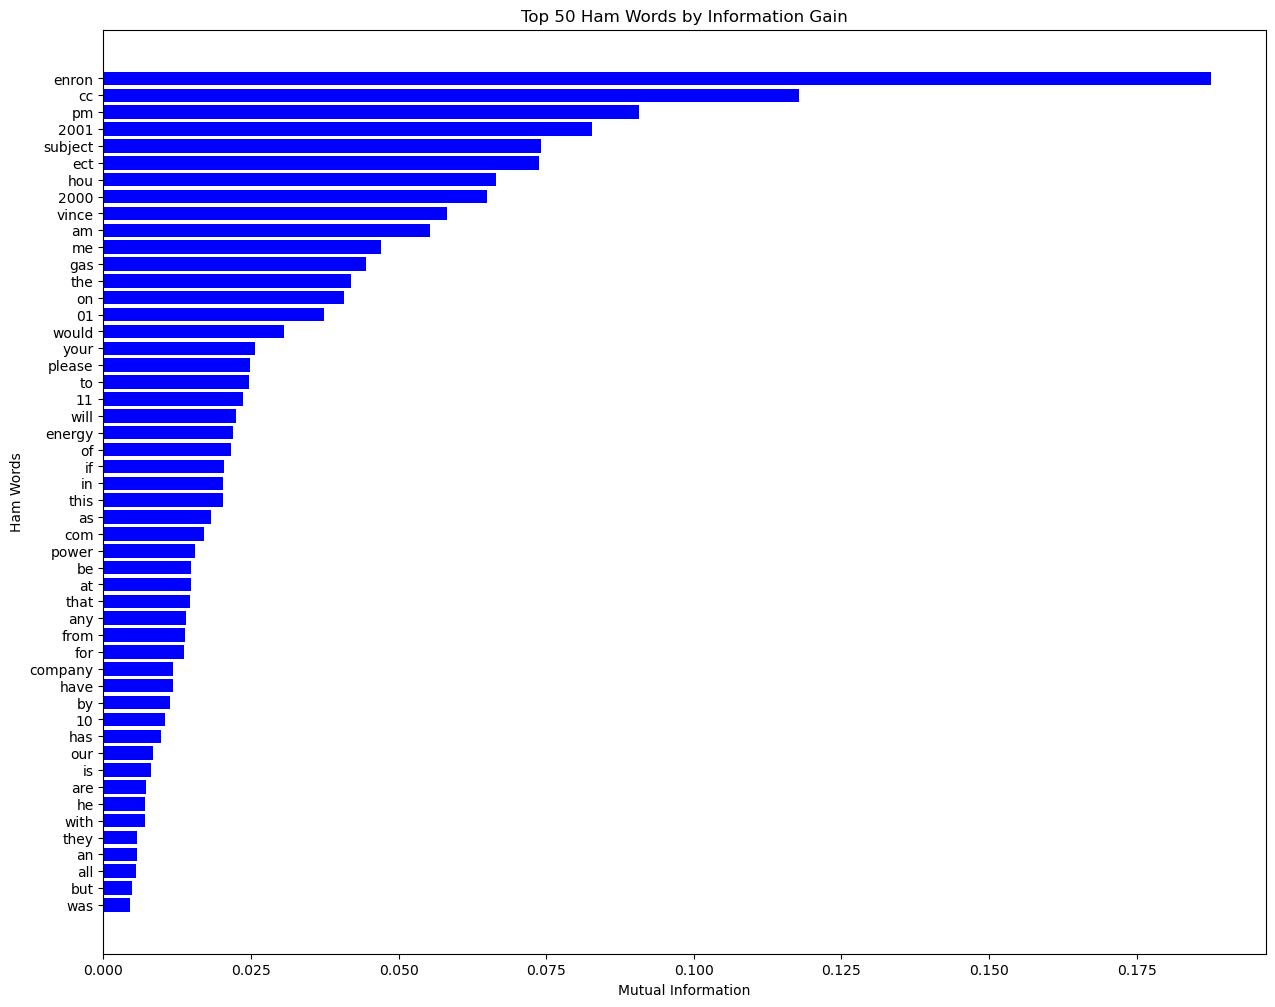

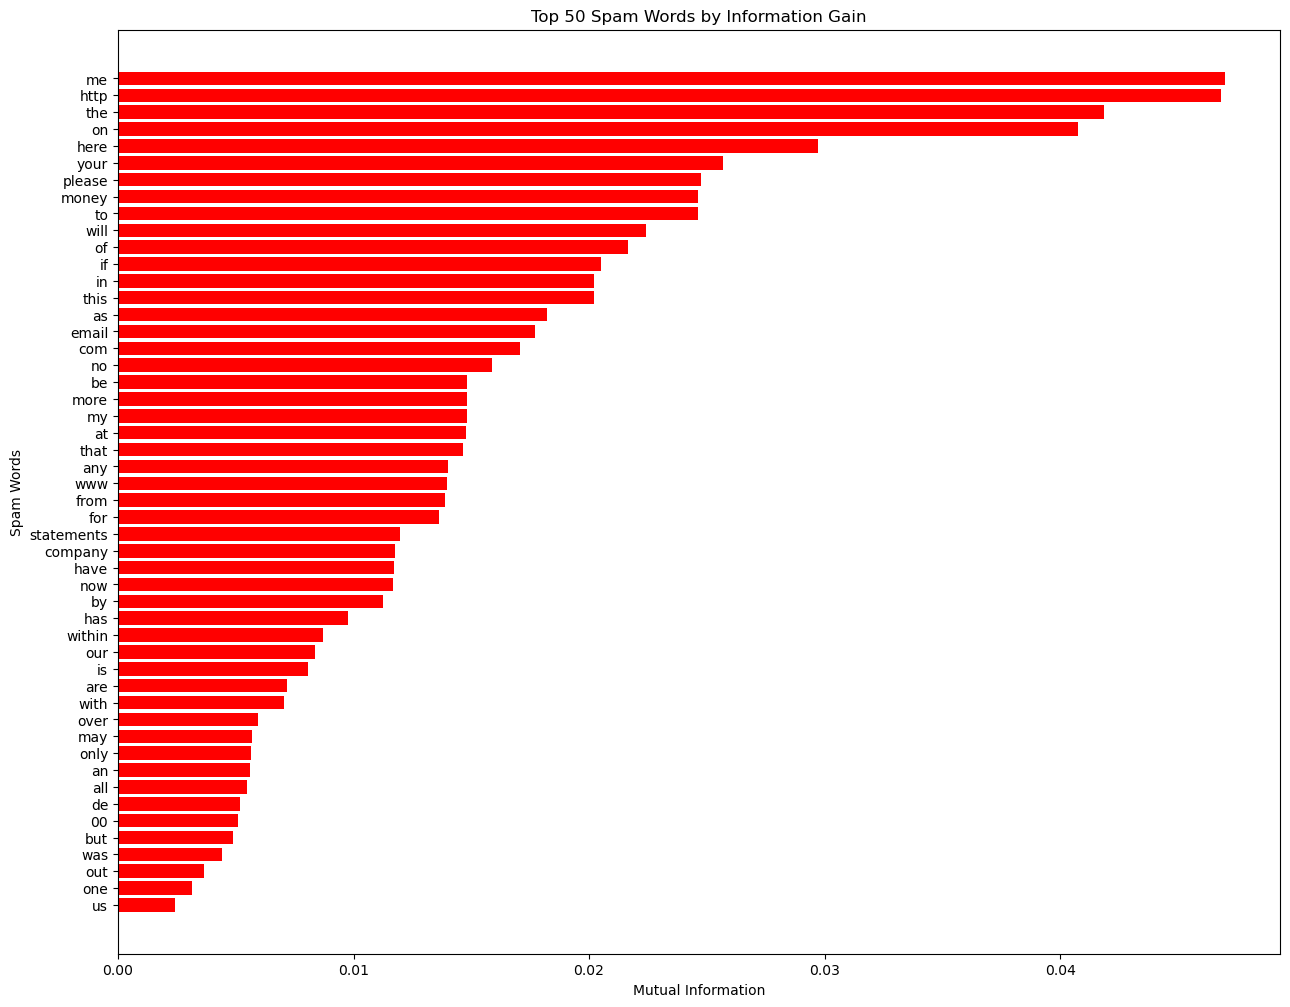

In [16]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from collections import Counter

mi = mutual_info_classif(X_train_multi, y_train, discrete_features=True)
feature_names = vectorizer.get_feature_names_out()

mi_df = pd.DataFrame({'word': feature_names, 'mutual_info': mi})
mi_df = mi_df.sort_values(by='mutual_info', ascending=False)

ham_word_counts = Counter()
spam_word_counts = Counter()

for message, label in zip(X_train, y_train):
    words = message.split()
    if label == 'ham':
        ham_word_counts.update(words)
    else:
        spam_word_counts.update(words)

# Convert counters to DataFrames for easy merging
ham_df = pd.DataFrame(ham_word_counts.items(), columns=['word', 'ham_count'])
spam_df = pd.DataFrame(spam_word_counts.items(), columns=['word', 'spam_count'])

# Merge with the mutual information DataFrame
mi_df = mi_df.merge(ham_df, on='word', how='left').merge(spam_df, on='word', how='left')
mi_df = mi_df.fillna(0)  # Fill NaNs with 0


N = 50
top_ham_words = mi_df.nlargest(N, 'ham_count')
top_spam_words = mi_df.nlargest(N, 'spam_count')

# Plot for Ham words
plt.figure(figsize=(15, 12))
top_ham_words = top_ham_words.sort_values(by='mutual_info', ascending=False) 
plt.barh(top_ham_words['word'], top_ham_words['mutual_info'], color='blue')
plt.xlabel('Mutual Information')
plt.ylabel('Ham Words')
plt.title('Top 50 Ham Words by Information Gain')
plt.gca().invert_yaxis()
plt.show()

# Plot for Spam words
plt.figure(figsize=(15, 12))
top_spam_words = top_spam_words.sort_values(by='mutual_info', ascending=False)  
plt.barh(top_spam_words['word'], top_spam_words['mutual_info'], color='red')
plt.xlabel('Mutual Information')
plt.ylabel('Spam Words')
plt.title('Top 50 Spam Words by Information Gain')
plt.gca().invert_yaxis()
plt.show()